# Welcome to your first Markov chain! This simple mixing time example examines Colorado Congressional Districts chains from 3 different seeds and outputs charts to observe how the initial state impacts the visual and quantitative qualities of the chain.

### Some Notes:

Please make sure you have the file tree as described, it will make running this chain MUCH easier. 

It is quite likely you will end up with numerous errors as you try to run this. Try your best to see what the error is talking about and ask questions as necessary! 

If errors persist, it might be necessary to restart this notebook. Above, go to Kernel -> Restart & Run All.

If you don't have all of these packages installed, try entering the command "pip install package" where 'package' is the name of the filepack that follows import below.

FILE TREE
** Make sure your files/folders match this - names and locations! **

Redistricting Course Folder

--Data

    --CO_Shapefile_2018_Jan2020

        --co_precincts.cpg

        --co_precincts.dbf

        --co_precincts.prj

        --co_precincts.shx

        --co_precincts.shp
    
--Outputs  (Only if you want to save the results)

    --Benchmarking   (Only if you want to save the results)

--Gerrychain Intro (CO) (this document!)

--Grid Graphs Intro

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import json
import networkx as nx
import time
import os
import csv
import networkx as nx
import math
import pickle


from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.constraints.validity import within_percent_of_ideal_population
from gerrychain.metrics import mean_median,efficiency_gap
from gerrychain.proposals import recom
from functools import partial
from gerrychain.tree import recursive_tree_part

from tqdm import tqdm

The next 2 cells read in the precinct data into a graph (for visuals) and a Geopandas Dataframe (for quantitative data).

Note these two steps may take up to 5ish minutes, depending on the speed of your computer.

In [22]:
graph = Graph.from_file("./MA-shapefiles/MA_precincts_12_16.shp")

/home/jovyan/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {836, 1278}
  warnings.warn(


In [23]:
df = gpd.read_file("./MA-shapefiles/MA_precincts_12_16.shp")

Here are the column labels in this dataframe:

In [24]:
for col in df.columns:
    print(col)

DISTRICT
NAME
Shape_Le_1
Shape_Area
TOWN
WARD
PRECINCT
SEN12D
SEN12R
PRES12D
PRES12R
SEN13D
SEN13R
SEN14D
SEN14R
PRES16D
PRES16R
CD
SEND
HDIST
NAME10
GOV14R
GOV14D
GOV14I
GOV14U1
GOV14U2
GOV18R
GOV18D
SEN18D
SEN18R
SEN18U
RSHARE
TOTPOP
NH_WHITE
NH_BLACK
NH_AMIN
NH_ASIAN
NH_NHPI
NH_OTHER
NH_2MORE
HISP
H_WHITE
H_BLACK
H_AMIN
H_ASIAN
H_NHPI
H_OTHER
H_2MORE
VAP
HVAP
WVAP
BVAP
AMINVAP
ASIANVAP
NHPIVAP
OTHERVAP
2MOREVAP
geometry


The next 2 cells set up some variables to connect our chains to the correct columns in the precinct.shp file. We need to define the election level (congressional/state upper/state lower), elections, and election data (D/R votes).

In [25]:
global unique_label 
unique_label = "PRECID"  #Unique identifier for the voting district

global population_col
population_col = "TOTPOP" 

global district_col_CD
district_col_CD = "CD116FP" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)
global district_col_SLD
district_col_SLD = "SLDLST" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)
global district_col_SUD
district_col_SUD = "SLDUST" #Change for: state house (SLDLST) or house senate district (SLDUST) or congressional (CD116FP)


global county_col
county_col = "COUNTYFP"

In [26]:
#Input the elections you are interested in

election_names = [
    "GOV", "AG", "SEC", "TRE", "REG"
]

election_columns = [
    ["GOV18D", "GOV18R"], ["AG18D","AG18R"], ["SOS18D","SOS18R"],["TRE18D","TRE18R"],["REG18D","REG18R"]
]

Define number of districts in each election level.

In [27]:
# Number of districts in Congressional, State Senate, State House
num_elections = len(election_names)
num_districts_CD = 7 
num_districts_SUD = 35
num_districts_SLD = 65

This sets up the elections list for future data.

In [28]:
elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

Define your updaters to keep track of info throughout the Markov chain

In [29]:
# updaters keep track of info throughout the markov chain

updaters = {"population": updaters.Tally(population_col, alias="population"),
            "cut_edges": cut_edges}

election_updaters = {election.name: election for election in elections}

updaters.update(election_updaters)

Find total population and ideal population per district for all 3 election levels

In [30]:
enacted_plan = GeographicPartition(graph, assignment=district_col_CD, updaters=updaters)
total_pop = sum(enacted_plan["population"].values())

ideal_pop_CD = int(total_pop/7)   # 7 Congressional seats
ideal_pop_SUD = int(total_pop/35)   # 35 State Senate seats   
ideal_pop_SLD = int(total_pop/65)   # 65 State House seats

print("Total population:", total_pop)
print("Ideal CD population:", ideal_pop_CD)
print("Ideal SUD population:", ideal_pop_SUD)
print("Ideal SLD population:", ideal_pop_SLD)

KeyError: 'CD116FP'

Create a few random seed plans to start Markov chains from:

In [11]:
seeds_CD = []

for i in range(3):
    seeds_CD.append(recursive_tree_part(graph, range(7), ideal_pop_CD, population_col, .005, 1))

Convert these seeds to Partition objects so we can compute election results by district, etc. Ensure you end up with a GeographicPartition with (#districts) parts.

In [12]:
seed_partitions_CD = []

for i in range(len(seeds_CD)):
    seed_partitions_CD.append(GeographicPartition(graph, assignment=seeds_CD[i], updaters=updaters))

seed_partitions_CD

[<GeographicPartition [7 parts]>,
 <GeographicPartition [7 parts]>,
 <GeographicPartition [7 parts]>]

Now collect Dem percentage by district for each election and each seed plan

In [13]:
cuts=[]
AGDV=[]
SECDV=[]
TREDV=[]
GOVDV=[]
REGDV=[]

i=0
for i in range(len(seed_partitions_CD)):
      
    cuts.append(len(cut_edges(seed_partitions_CD[i])))
    AGDV.append(sorted(list(seed_partitions_CD[i]['AG'].percents("Democratic"))))
    SECDV.append(sorted(list(seed_partitions_CD[i]['SEC'].percents("Democratic"))))
    TREDV.append(sorted(list(seed_partitions_CD[i]['TRE'].percents('Democratic'))))
    GOVDV.append(sorted(list(seed_partitions_CD[i]['GOV'].percents("Democratic"))))
    REGDV.append(sorted(list(seed_partitions_CD[i]['REG'].percents('Democratic'))))

df_cuts=pd.DataFrame(cuts)
df_AGDV=pd.DataFrame(AGDV)
df_SECDV=pd.DataFrame(SECDV)
df_TREDV=pd.DataFrame(TREDV)
df_GOVDV=pd.DataFrame(GOVDV)
df_REGDV=pd.DataFrame(REGDV)

Take a look at what you just did! You found, for instance, the % democratic vote in the 2018 Attorney General election in all 7 districts in all three of our seed plans. You did this by overlaying precinct voter data with geographic seed plans!

In [14]:
df_AGDV

,0,1,2,3,4,5,6
0,0.361049,0.460013,0.471887,0.520642,0.539976,0.647202,0.709815
1,0.400804,0.440496,0.486080,0.507337,0.566055,0.607233,0.700398
2,0.413970,0.417155,0.495454,0.534589,0.553772,0.577138,0.728713


Plot the sorted Dem percentage by district for our random seeds

Text(0.5, 1.0, 'Dem Voting Percentage: Attorney General')

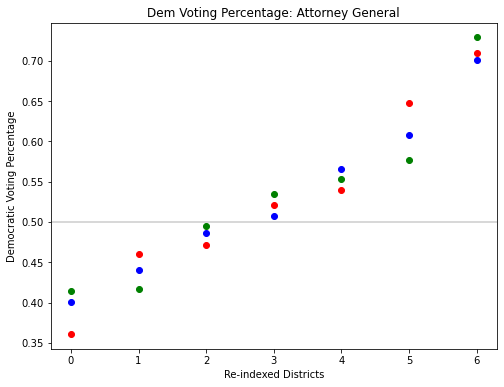

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

#Loops through the above dataframe and grabs the value in the jth row for each column
colorlist = ['red', 'blue', 'green']
plt.plot(df_AGDV.iloc[0], "o", color=colorlist[0])
plt.plot(df_AGDV.iloc[1], "o", color=colorlist[1])
plt.plot(df_AGDV.iloc[2], "o", color=colorlist[2])

plt.xlabel('Re-indexed Districts')
plt.ylabel('Democratic Voting Percentage')
plt.title('Dem Voting Percentage: Attorney General')

Plot the maps corresponding to each of these seed districting plans so we can see what the actual plans look like

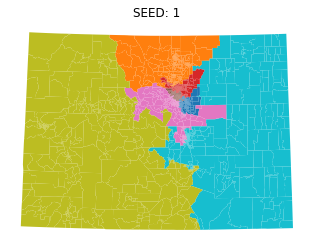

In [16]:
j = 0

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y

part = seed_partitions_CD[j]
pos = {node:(c_x[node],c_y[node]) for node in graph.nodes}
df["part"]=df.index.map(dict(part.assignment))
f, ax = plt.subplots(1)
#remove x axis and y axis
plt.yticks([])
plt.xticks([])
#remove the worthless frame on the map
plt.box(on=False)#increment i in the loop to number the seeds
plt.title("SEED: "+str(j+1))#df.plot(ax=ax, column="part",cmap='Blues', edgecolor='black', linewidth=0.2)
df.plot(ax=ax,column="part", cmap = 'tab10')#save figure to outputs folder
#use str(i) in a loop to number the seed plans
#dpi is the file resolution
#plt.savefig(newdir+"SEED: "+str(i)+".png", dpi=1500)
plt.show()

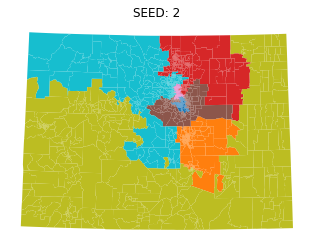

In [17]:
j = 1

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y

part = seed_partitions_CD[j]
pos = {node:(c_x[node],c_y[node]) for node in graph.nodes}
df["part"]=df.index.map(dict(part.assignment))
f, ax = plt.subplots(1)
#remove x axis and y axis
plt.yticks([])
plt.xticks([])
#remove the worthless frame on the map
plt.box(on=False)#increment i in the loop to number the seeds
plt.title("SEED: "+str(j+1))#df.plot(ax=ax, column="part",cmap='Blues', edgecolor='black', linewidth=0.2)
df.plot(ax=ax,column="part", cmap = 'tab10')#save figure to outputs folder
#use str(i) in a loop to number the seed plans
#dpi is the file resolution
#plt.savefig(newdir+"SEED: "+str(i)+".png", dpi=1500)
plt.show()

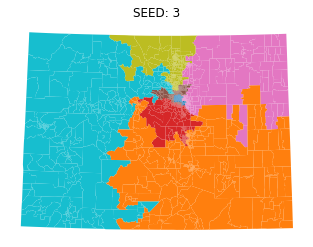

In [18]:
j = 2

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y

part = seed_partitions_CD[j]
pos = {node:(c_x[node],c_y[node]) for node in graph.nodes}
df["part"]=df.index.map(dict(part.assignment))
f, ax = plt.subplots(1)
#remove x axis and y axis
plt.yticks([])
plt.xticks([])
#remove the worthless frame on the map
plt.box(on=False)#increment i in the loop to number the seeds
plt.title("SEED: "+str(j+1))#df.plot(ax=ax, column="part",cmap='Blues', edgecolor='black', linewidth=0.2)
df.plot(ax=ax,column="part", cmap = 'tab10')#save figure to outputs folder
#use str(i) in a loop to number the seed plans
#dpi is the file resolution
#plt.savefig(newdir+"SEED: "+str(i)+".png", dpi=1500)
plt.show()

Oh, don't those look lovely!  They also look very different from each other, so it should be interesting to use them as starting points for Markov chains and compare the results.  The longer the chains, the more their distributions should look similar - so we can try to determine mixing time experimentally.

One way to do this is to run a single, long chain (say, 10,000 steps?) and plot the distributions obtained after varying lengths (1000 steps?  2000?)  The idea is to plot a few different lengths so that you can see the chain gradually mixing; it will take some experimenting to figure out the right lengths - which is kind of the whole point!

However, I have a feeling such a process will take longer than class time! Just to demonstrate, we're going to allow 5% population variance (meaning there are less rejections) and only shoot for 100 steps to start. You can most definitely try these stricter, more insightful tests on your own time!

Let's go ahead and define our chains for each of our random seeds - this is where you can adjust chain steps (2nd to last line of this cell) and population tolerance (the right most code bit, about 8 lines from the bottom).

In [19]:
proposals = []
compactness_bounds = []
chains=[]

for i in range(len(seed_partitions_CD)):

    proposals.append(partial(recom, 
                             pop_col= population_col, 
                             pop_target= ideal_pop_CD, 
                             epsilon=0.005, 
                             node_repeats=1
    ))

#     compactness_bounds.append(constraints.UpperBound(
#         lambda p: len(p["cut_edges"]), 
#         2 * len(initial_partitions[i]["cut_edges"])
#     ))

    chains.append(MarkovChain(
        proposal=proposals[i],
        constraints=[
            constraints.within_percent_of_ideal_population(seed_partitions_CD[i], 0.05)#,compactness_bounds[i]
          #constraints.single_flip_contiguous#no_more_discontiguous
        ],
        accept=accept.always_accept,
        initial_state=seed_partitions_CD[i],
        total_steps=1000 
    ))

### Now let's run these 3 chains!

In [20]:
cuts=[[],[],[]]
AGDV=[[],[],[]]
SECDV=[[],[],[]]
TREDV=[[],[],[]]
GOVDV=[[],[],[]]
REGDV=[[],[],[]]

for i in range(3):
    t = 0
    for part in chains[i].with_progress_bar():
        
        cuts[i].append(len(part["cut_edges"]))
        AGDV[i].append(sorted(part["AG"].percents("Democratic")))
        SECDV[i].append(sorted(part["SEC"].percents("Democratic")))
        TREDV[i].append(sorted(part["TRE"].percents("Democratic")))
        GOVDV[i].append(sorted(part["GOV"].percents("Democratic")))
        REGDV[i].append(sorted(part["REG"].percents("Democratic")))


KeyboardInterrupt: 

Let's see what one of these looks like! Notice how the outer lists represent each seed, the middle lists are steps in the chain and the inner lists contain the democratic voting percentages for each district ordered from least to greatest.

In [ ]:
AGDV

You can use this bit of code if you'd like to save your chain for importation later!
To import it again later, import pickle and use:
with open ('outfile', 'rb') as fp:
    itemlist = pickle.load(fp)

In [22]:
# with open('./Outputs/Benchmarking/CD_Chain_results_AGDV.txt', 'wb') as fp:
#     pickle.dump(AGDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_SECDV.txt', 'wb') as fp:
#     pickle.dump(SECDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_TREDV.txt', 'wb') as fp:
#     pickle.dump(TREDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_GOVDV.txt', 'wb') as fp:
#     pickle.dump(GOVDV, fp)
# with open('./Outputs/Benchmarking/CD_Chain_results_REGDV.txt', 'wb') as fp:
#     pickle.dump(REGDV, fp)

Create a function to draw the plots!

In [23]:
def draw_plot(data, offset, edge_color, fill_color):
    pos = 5*np.arange(data.shape[1])+1+offset
    #bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    bp = ax.boxplot(data, positions= pos,widths=.5, whis=[1,99],showfliers=False, patch_artist=True, manage_ticks=False,zorder=4)
    for element in ['boxes', 'whiskers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color,zorder=4)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,zorder=0)

In [24]:
colors = ['blue','green','purple']
labels= ['Seed1','Seed2','Seed3']

Plot results for Governor's race.  

First plot first 100 steps of each chain:

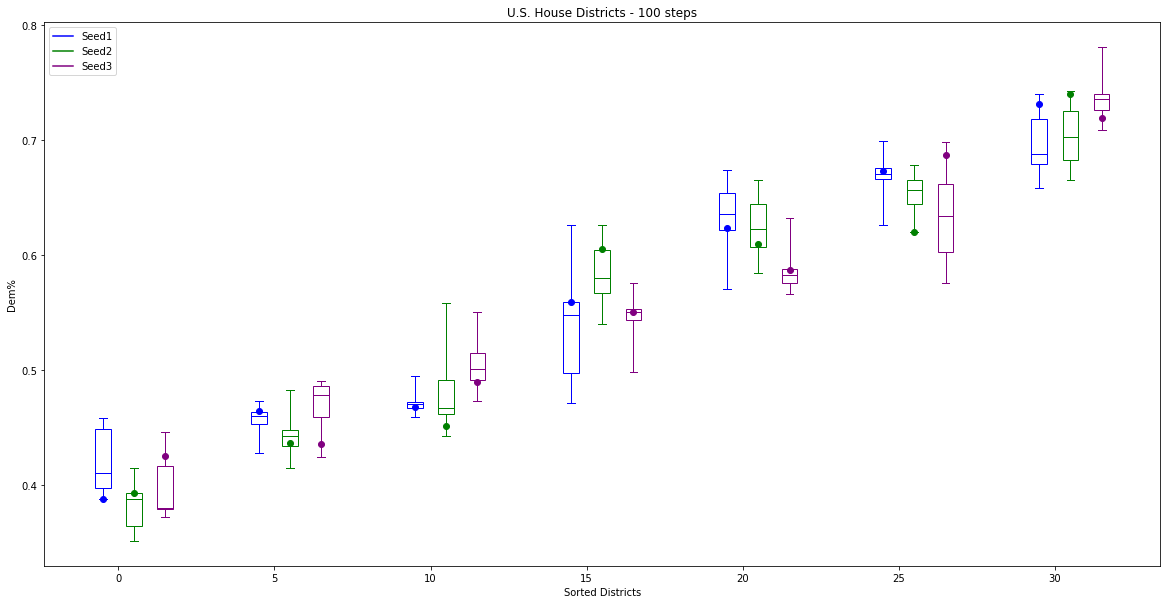

In [25]:
fig, ax = plt.subplots(figsize=(20,10))

shift = [i * 5 for i in range(7)];
shiftblue = [item - 0.5 for item in shift];
shiftgreen = [item + 0.5 for item in shift];
shiftpurp = [item + 1.5 for item in shift]

draw_plot(np.array(GOVDV[0][0:99]),-1.5,colors[0],'w')
plt.plot(shiftblue, GOVDV[0][0], "o", color = colors[0])

draw_plot(np.array(GOVDV[1][0:99]),-.5,colors[1],'w')
plt.plot(shiftgreen, GOVDV[1][0], "o", color = colors[1])

draw_plot(np.array(GOVDV[2][0:99]),.5,colors[2],'w')
plt.plot(shiftpurp, GOVDV[2][0], "o", color = colors[2])

plt.ylabel("Dem%")
plt.xlabel("Sorted Districts")
# ax.set_xticks([])
for i in range(3):
    plt.plot([],[],color=colors[i],label=labels[i])
plt.legend()
plt.title("U.S. House Districts - 100 steps")

# plt.savefig("./Outputs/Benchmarking/CD_Chains_100steps")
plt.show()

Now plot 1000 steps:

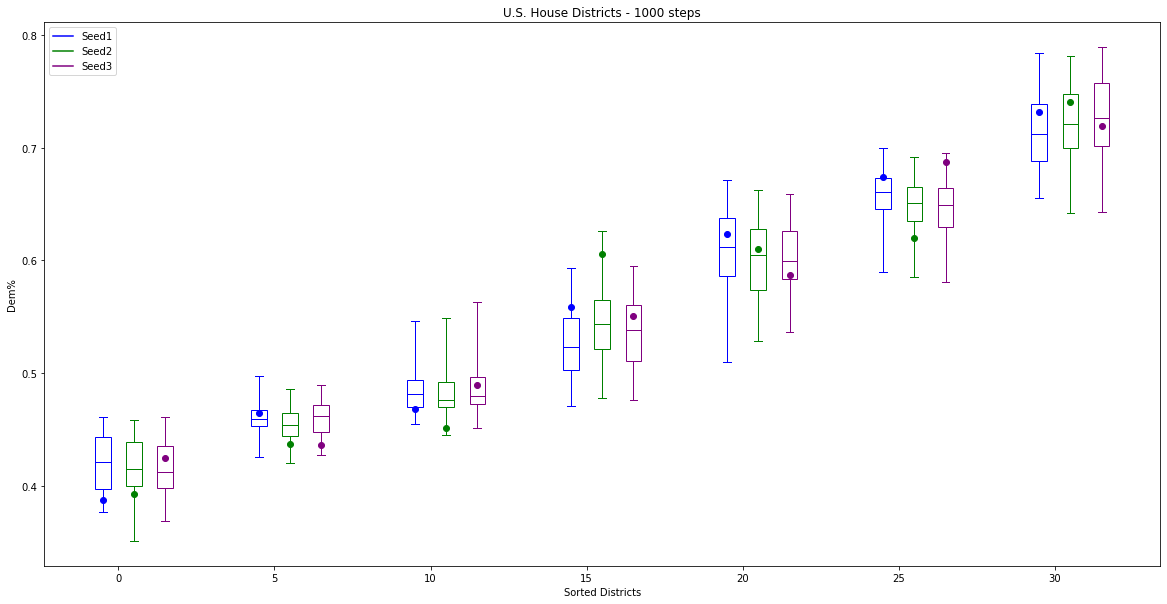

In [26]:
fig, ax = plt.subplots(figsize=(20,10))

shift = [i * 5 for i in range(7)];
shiftblue = [item - 0.5 for item in shift];
shiftgreen = [item + 0.5 for item in shift];
shiftpurp = [item + 1.5 for item in shift]

draw_plot(np.array(GOVDV[0][0:999]),-1.5,colors[0],'w')
plt.plot(shiftblue, GOVDV[0][0], "o", color = colors[0])

draw_plot(np.array(GOVDV[1][0:999]),-.5,colors[1],'w')
plt.plot(shiftgreen, GOVDV[1][0], "o", color = colors[1])

draw_plot(np.array(GOVDV[2][0:999]),.5,colors[2],'w')
plt.plot(shiftpurp, GOVDV[2][0], "o", color = colors[2])

plt.ylabel("Dem%")
plt.xlabel("Sorted Districts")
# ax.set_xticks([])
for i in range(3):
    plt.plot([],[],color=colors[i],label=labels[i])
plt.legend()
plt.title("U.S. House Districts - 1000 steps")

# plt.savefig("./Outputs/Benchmarking/CD_Chains_100steps")
plt.show()

Now plot all 10,000 steps of each chain:

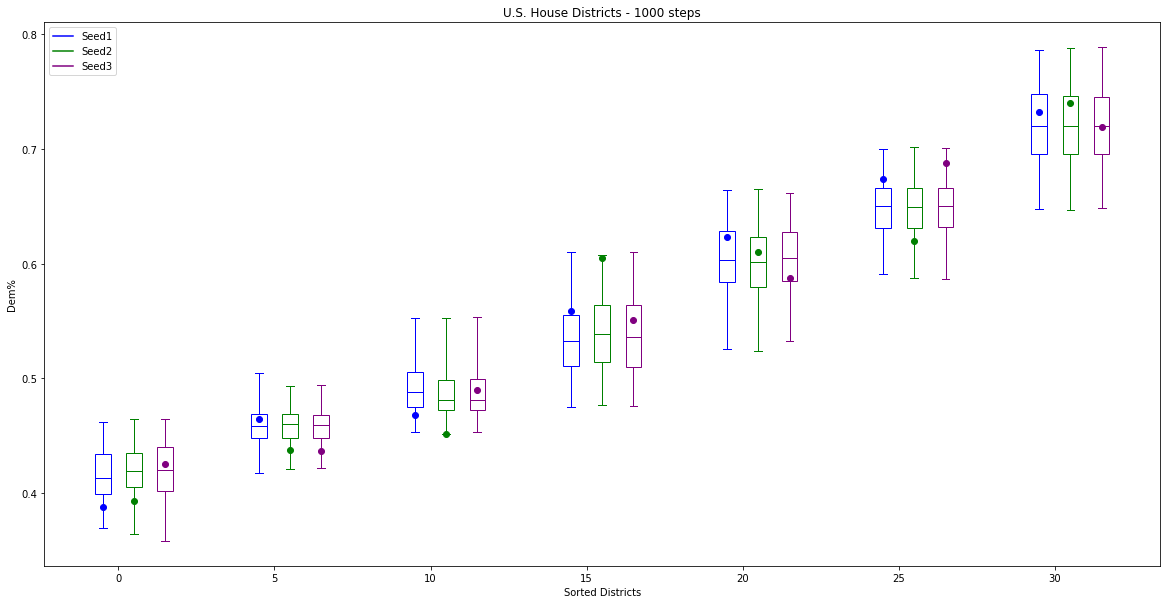

In [27]:
fig, ax = plt.subplots(figsize=(20,10))

shift = [i * 5 for i in range(7)];
shiftblue = [item - 0.5 for item in shift];
shiftgreen = [item + 0.5 for item in shift];
shiftpurp = [item + 1.5 for item in shift]

draw_plot(np.array(GOVDV[0]),-1.5,colors[0],'w')
plt.plot(shiftblue, GOVDV[0][0], "o", color = colors[0])

draw_plot(np.array(GOVDV[1]),-.5,colors[1],'w')
plt.plot(shiftgreen, GOVDV[1][0], "o", color = colors[1])

draw_plot(np.array(GOVDV[2]),.5,colors[2],'w')
plt.plot(shiftpurp, GOVDV[2][0], "o", color = colors[2])

plt.ylabel("Dem%")
plt.xlabel("Sorted Districts")
# ax.set_xticks([])
for i in range(3):
    plt.plot([],[],color=colors[i],label=labels[i])
plt.legend()
plt.title("U.S. House Districts - 1000 steps")

# plt.savefig("./Outputs/Benchmarking/CD_Chains_100steps")
plt.show()

And of course you could do these boxplots for the other elections as well!

We can also extract information to plots histograms for seat share.

In [28]:
seats_GOV = [[],[],[]]

for i in range(3):
    for j in range(len(GOVDV[i])):
        numseats=0
        for k in range(7):
            if GOVDV[i][j][k]>0.5:
                numseats +=1
        seats_GOV[i].append(numseats)


Plot Dem seat share for first 100 steps of each chain:

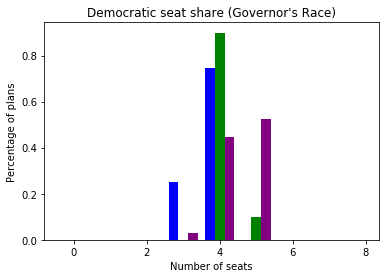

In [29]:
plt.hist((seats_GOV[0][0:99], seats_GOV[1][0:99], seats_GOV[2][0:99]), color = ("blue", "green", "purple"), bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8], density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of seats")
plt.title("Democratic seat share (Governor's Race)")
#plt.legend()
plt.show()

Plot 1000 steps:

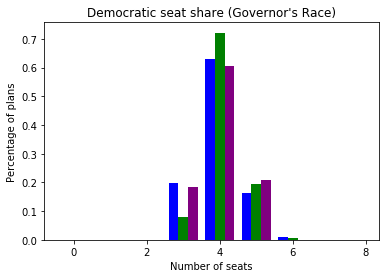

In [30]:
plt.hist((seats_GOV[0][0:999], seats_GOV[1][0:999], seats_GOV[2][0:999]), color = ("blue", "green", "purple"), bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8], density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of seats")
plt.title("Democratic seat share (Governor's Race)")
#plt.legend()
plt.show()

Plot all 10,000 steps for each chain:

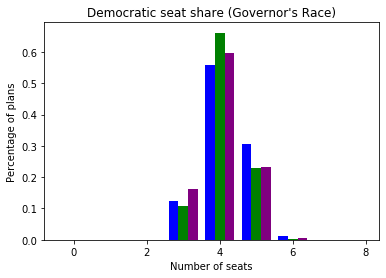

In [31]:
plt.hist((seats_GOV[0], seats_GOV[1], seats_GOV[2]), color = ("blue", "green", "purple"), bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8], density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of seats")
plt.title("Democratic seat share (Governor's Race)")
#plt.legend()
plt.show()

Since we collected data about the number of cut edges in each plan, we can plot histograms for cut edges for each chain as well.

First plot histograms for first 100 steps in each chain:

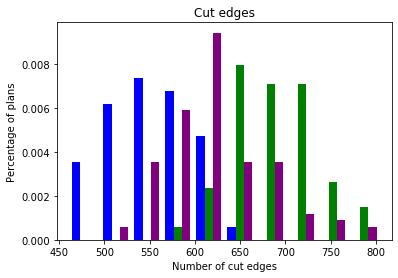

In [32]:
plt.hist((cuts[0][0:99], cuts[1][0:99], cuts[2][0:99]), color = ("blue", "green", "purple"), density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of cut edges")
plt.title("Cut edges")
#plt.legend()
plt.show()

Plot 1000 steps:

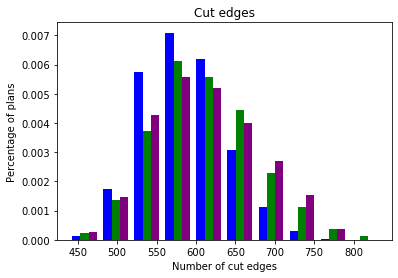

In [33]:
plt.hist((cuts[0][0:999], cuts[1][0:999], cuts[2][0:999]), color = ("blue", "green", "purple"), density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of cut edges")
plt.title("Cut edges")
#plt.legend()
plt.show()

Plot all 10,000 steps for each chain:

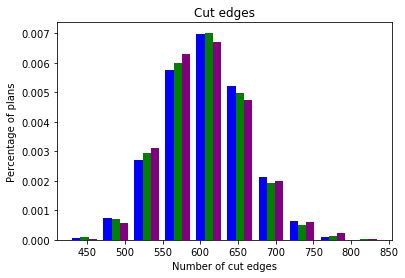

In [34]:
plt.hist((cuts[0], cuts[1], cuts[2]), color = ("blue", "green", "purple"), density=True)
plt.ylabel("Percentage of plans")
plt.xlabel("Number of cut edges")
plt.title("Cut edges")
#plt.legend()
plt.show()